# GAN Implementation
Concepts:
Two networks, Generator (G) and Discriminator (D) play a game of fooling each other. G is trying to trick D by generating fake data and D is trying to get better at discriminating fake data from real. 

D is trained on real *and* fake data; G is trained on fake data labelled as true while using D's gradients to get better at generating fake data. As the game of fooling continues, G gets better as generating fake data and D gets better at discriminating fake data.

Binary cross-entropy or Kullback-Liebler (KL) Divergence: the distance between two (probability for KD) distributions.

DCGAD (Deep Convolution Generative Adversarial Networks) are more intended for images.

# Imports

We start with imports and parameters 

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import keras
from keras.models import Model, Sequential
from keras.layers import Dense, BatchNormalization, Reshape, Dropout, LeakyReLU, Input, Flatten
from keras.optimizers import Adam
from keras.datasets import mnist
from keras.utils import plot_model

from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [13]:
# CHANGE THIS PATH TO YOUR FOLDER'S PATH
path = "/content/gdrive/MyDrive/corsoDL_UniVPM/GAN_Ese_Master"

if not os.path.exists(os.path.join(path, "gen_images")):
  os.mkdir(os.path.join(path, "gen_images"))

In [14]:
# Parameters
epochs = 20000
mnist_shape = (28,28,1)
batch_size = 128
noise_shape = (100,)    # the bigger the random input vector, the more "random" the generated images will be
save_every = 1000

We will use the MNIST dataset:

<img src='https://upload.wikimedia.org/wikipedia/commons/2/27/MnistExamples.png'> <br>
It displays hand-written digits from 0 to 9. We want G to be able to generate new (*fake*) images that could be extracted from this dataset.

# GAN structure

<img src='https://developers.google.com/static/machine-learning/gan/images/gan_diagram.svg'>

The Generator model receives random (white) noise as input and processes it in order to produce images that look like the real ones. <br> The backpropagation of the error cannot take place without the Discriminator, which is a classifier: 


1.   G generates a new sample from random noise;
2.   D receives the generated samples and the real ones;
3.   D has to classify the images it receives as "real" or "fake".

D is trained to recognize that an image is fake, and G is trained to generate images that D cannot recognize as fake. 


# Generator

In [21]:
def build_generator(noise_shape, mnist_shape):
    # It's a Fully Connected Neueal Network
    noise = Input(shape=noise_shape)    
    
    # first fully connected + activation + normalization
    x = Dense(256, input_shape=(noise_shape))(noise)  # fully connected layer
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    # second fully connected + activation + normalization
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    # third fully connected + activation + normalization
    x = Dense(1024)(x)
    x = LeakyReLU(alpha=0.2)(x)
    x = BatchNormalization(momentum=0.8)(x)
    # final fully connected
    # mnist_shape = (28x28x1) --> np.prod(mnist_shape) = 28*28 = 784
    # the final Dense has as many neurons as many pixels there are in the original images
    x = Dense(np.prod(mnist_shape), activation='tanh')(x) #hyperbolic tangent --X everything is [-1;1]
    x = Reshape(mnist_shape)(x) # (784,1) --> (28, 28, 1)
    
    model = Model(noise, x)
    
    # print model summary
    model.summary()
    
    img = model(noise)
    return Model(noise, img)

In [22]:
G = build_generator(noise_shape, mnist_shape)
# input*weight + bias --> weight and bias are the parameters to train
# the first layer has 25856 parameters = 256weights*100inputs + 256 biases

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 100)]             0         
                                                                 
 dense_10 (Dense)            (None, 256)               25856     
                                                                 
 leaky_re_lu_7 (LeakyReLU)   (None, 256)               0         
                                                                 
 batch_normalization_3 (Batc  (None, 256)              1024      
 hNormalization)                                                 
                                                                 
 dense_11 (Dense)            (None, 512)               131584    
                                                                 
 leaky_re_lu_8 (LeakyReLU)   (None, 512)               0         
                                                           

# Discriminator

In [23]:
def build_discriminator(mnist_shape):
    # a classifier
    input = Input(shape=mnist_shape)
    
    #2D images become 1D arrays: 28x28x1 --> 784,1
    x = Flatten()(input)  
    # first fully-connected + activation
    x = Dense(512)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # x = BatchNormalization()(x)
    # second fully-connected + activation
    x = Dense(256)(x)
    x = LeakyReLU(alpha=0.2)(x)
    # output fully-connected: probability that the input image is real 
    x = Dense(1, activation='sigmoid')(x)
    
    model = Model(input, x)
    model.summary()
    img = model(input)
    return Model(input, img)

In [24]:
D = build_discriminator(mnist_shape)

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_14 (Dense)            (None, 512)               401920    
                                                                 
 leaky_re_lu_10 (LeakyReLU)  (None, 512)               0         
                                                                 
 dense_15 (Dense)            (None, 256)               131328    
                                                                 
 leaky_re_lu_11 (LeakyReLU)  (None, 256)               0         
                                                                 
 dense_16 (Dense)            (None, 1)                 257

# Compile

In [25]:
G.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')
D.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy', metrics=['accuracy'])

# Build GAN

G is never trained alone: we train D to correctly label real and fake images, then we train the whole GAN (D+G) so that G generates images that are closer to what D would label as "real".

In [26]:
input = Input(shape=noise_shape)
fake_image = G(input)
D.trainable = False # we are "freezing" D's parameters: D won't be trained at first
real_or_fake_prob = D(fake_image)
# noise -> G -> D
D_G_model = Model(input, real_or_fake_prob)
D_G_model.compile(optimizer=Adam(0.0002, 0.5), loss='binary_crossentropy')

D_G_model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_8 (InputLayer)        [(None, 100)]             0         
                                                                 
 model_9 (Functional)        (None, 28, 28, 1)         1493520   
                                                                 
 model_11 (Functional)       (None, 1)                 533505    
                                                                 
Total params: 2,027,025
Trainable params: 1,489,936
Non-trainable params: 537,089
_________________________________________________________________


In [27]:
def save_image(epoch):
    # we plot 5 x 5 grid of images and save it to disk along with epoch number
    rows = 10
    cols = 10
    
    noise = np.random.uniform(0, 1, (rows*cols, noise_shape[0]))
    images = G.predict(noise)
    
    # rescale
    images = 0.5 * images + 0.5
    
    # stuff to have 100 generated images all together in one 10x10 matrix
    fig, ax = plt.subplots(rows, cols)
    ctr = 0
    for i in range(rows):
        for j in range(cols):
            ax[i,j].imshow(images[ctr, :,:, 0], cmap='gray')
            ax[i,j].axis('off')
            ctr += 1
    if not os.path.exists('images'):
      os.makedirs('images')

    fname = os.path.join(path,'gen_images', 'mnist_{}.png'.format(int(epoch/save_every)))
    fig.savefig(fname)
    print('saved: {}'.format(fname))
    plt.close()

# Train

We will load the dataset, preprocess it and train the network

In [28]:
# Load dataset
(X_train, _), (_,_) = mnist.load_data()
X_train.shape

# center data
# standardization: img - img.mean / img.std
# centering: img - 255/2 / (255/2)
X_train = (X_train.astype('float32') - 127.5)/127.5

X_train = np.expand_dims(X_train, axis=3) # (28x28) --> (28x28x1)
print("X_train.shape =", X_train.shape)
print("mean = ", np.mean(X_train), "std = ", np.std(X_train))

###########
# Train
# we want to train discriminator by passing half batch of real and half batch of fake images
# class balance: if I have 10 classes I want the net to see the same amount of imgs for each class
half_batch = int(batch_size/2)
print('half batch size : {}'.format(half_batch))
for epoch in range(epochs):
    #### train discriminator
    # 1) real: get a batch of real images and train D to label tham as "real" (1)
    indices = np.random.randint(0, X_train.shape[0], half_batch)
    real_images = X_train[indices]    
    d_real_loss = D.train_on_batch(real_images, np.ones((half_batch, 1))) #np.ones = output 1 for each image
    
    # 2) fake: get a batch of fake images and train D to label tham as "fake" (0)
    noise = np.random.uniform(0, 1, (half_batch, noise_shape[0]))
    fake_images = G.predict(noise, verbose=0)
    d_fake_loss = D.train_on_batch(fake_images, np.zeros((half_batch, 1)))
    
    # Total D loss = loss on real data + loss on fake data
    d_loss = np.add(d_real_loss, d_fake_loss) / 2
    
    #### 3) train generator: we give the random input to the GAN (D+G)
    noise = np.random.uniform(0, 1, (batch_size, noise_shape[0]))
    g_loss = D_G_model.train_on_batch(noise, np.ones((batch_size, 1)))
    # in D_G_model, the Discriminator is NEVER trained, so it's only the Generator that 
    # improves its generative ability according to what the Discriminator has learnt in 1) and 2)
        
    if epoch % 500 == 0:
      print(f'Epoch: {epoch}, D_Loss:{d_loss[0]}, D_Acc:{d_loss[1],}, G_Loss:{g_loss}')

    if epoch % save_every == 0:        
        save_image(epoch)      

X_train.shape = (60000, 28, 28, 1)
mean =  -0.7386798 std =  0.6162155
half batch size : 64
Epoch: 0, D_Loss:0.8698620498180389, D_Acc:(0.5,), G_Loss:0.9543672800064087
4/4 [==============================] - 0s 3ms/step
saved: /content/gdrive/MyDrive/corsoDL_UniVPM/GAN_Ese_Master/gen_images/mnist_0.png
Epoch: 500, D_Loss:0.6175688803195953, D_Acc:(0.5390625,), G_Loss:0.7963272929191589
Epoch: 1000, D_Loss:0.5783383250236511, D_Acc:(0.8359375,), G_Loss:0.9672702550888062
4/4 [==============================] - 0s 3ms/step
saved: /content/gdrive/MyDrive/corsoDL_UniVPM/GAN_Ese_Master/gen_images/mnist_1.png
Epoch: 1500, D_Loss:0.5786908268928528, D_Acc:(0.6953125,), G_Loss:1.1366784572601318
Epoch: 2000, D_Loss:0.5897597372531891, D_Acc:(0.6484375,), G_Loss:1.1305128335952759
4/4 [==============================] - 0s 3ms/step
saved: /content/gdrive/MyDrive/corsoDL_UniVPM/GAN_Ese_Master/gen_images/mnist_2.png
Epoch: 2500, D_Loss:0.5778942108154297, D_Acc:(0.7109375,), G_Loss:1.02277874946594

# Test 

We are now ready to test the generator by passing random noise and checking what it generates

1/1 [==============================] - 0s 20ms/step


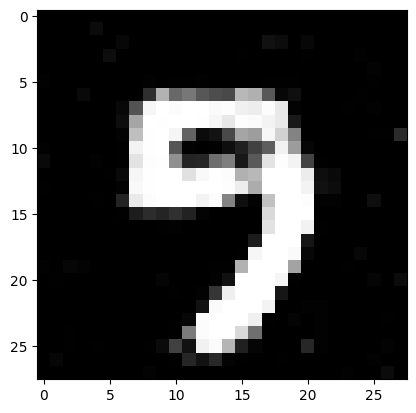

In [47]:
noise = np.random.uniform(0, 1, (1, noise_shape[0]))
image = G.predict(noise)

# Visualise
plt.imshow(image[0,:,:, 0], cmap='gray')

## controllo aggiornamento colab